In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("benjaminawd/new-york-times-articles-comments-2020")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-york-times-articles-comments-2020


In [16]:
import pandas as pd
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
articles_path = '/kaggle/input/new-york-times-articles-comments-2020/nyt-articles-2020.csv'
articles = pd.read_csv(articles_path, usecols=['headline'])
articles.dropna(inplace=True)

# Preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = re.sub(f'[{string.punctuation}]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing
articles['cleaned_headline'] = articles['headline'].apply(preprocess_text)



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


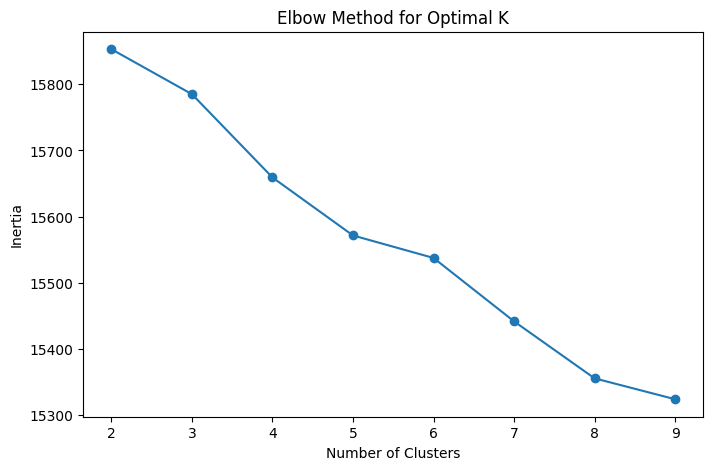

Top words per KMeans cluster:
{'Cluster 0': ['trump', 'donald', 'say', 'republican', 'election', 'administration', 'virus', 'campaign', 'president', 'court'], 'Cluster 1': ['home', 'california', 'million', 'sale', 'new', 'york', 'manhattan', 'brooklyn', 'nursing', 'sold'], 'Cluster 2': ['coronavirus', 'vaccine', 'test', 'case', 'latest', 'china', 'new', 'update', 'nyc', 'outbreak'], 'Cluster 3': ['new', 'pandemic', 'virus', 'time', 'day', 'life', 'covid', 'year', 'york', 'one'], 'Cluster 4': ['biden', 'joe', 'trump', 'win', 'lead', 'voter', 'sander', 'pick', 'debate', 'could']}


In [17]:
### KMeans Clustering ###
# Convert text to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(articles['cleaned_headline'])

# Find optimal clusters using the Elbow Method
inertia = []
k_values = range(2, 10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Train KMeans with optimal K
optimal_k = 5  # Manually set based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
articles['cluster'] = kmeans.fit_predict(X_tfidf)

# Extract top words per cluster
def get_top_words(model, feature_names, n_words=10):
    clusters_top_words = {}
    for i in range(model.n_clusters):
        words = [feature_names[idx] for idx in np.argsort(model.cluster_centers_[i])[-n_words:]]
        clusters_top_words[f'Cluster {i}'] = words[::-1]
    return clusters_top_words

print("Top words per KMeans cluster:")
print(get_top_words(kmeans, tfidf_vectorizer.get_feature_names_out()))

### LDA Topic Modeling ###



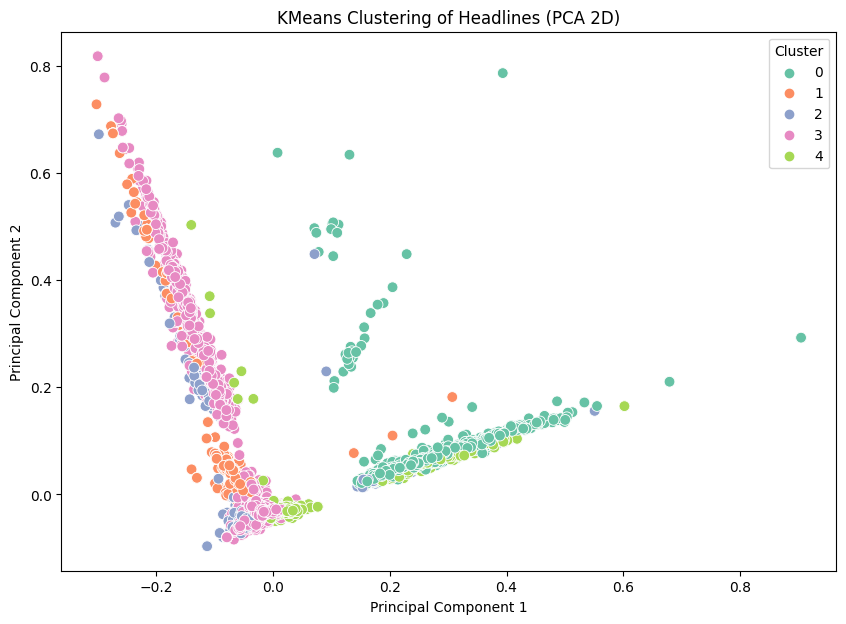

In [18]:
from sklearn.decomposition import PCA

# Reduce dimensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=articles['cluster'], palette='Set2', s=60)
plt.title('KMeans Clustering of Headlines (PCA 2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


This creates a scatter plot where:

Each point = a headline

The point's color = its assigned cluster from KMeans

So you're visualizing the cluster structure in a simplified space.

1. Cluster Structure is Visible
You can clearly see multiple distinct groupings of color (e.g. green, pink, purple).

This suggests KMeans found real structure in the headline data — it’s not just noise.

2. Some Overlap Exists
There’s some mixing at the boundaries between clusters, which is natural.

Headlines on similar topics (e.g. politics vs. health policy) can have semantic overlap, so that’s expected.

3. Outliers or Ambiguity
A few points are floating away from clusters — these could be:

Headlines that don't fit neatly into one topic

Very short/unique headlines

Possibly noise or underrepresented topics

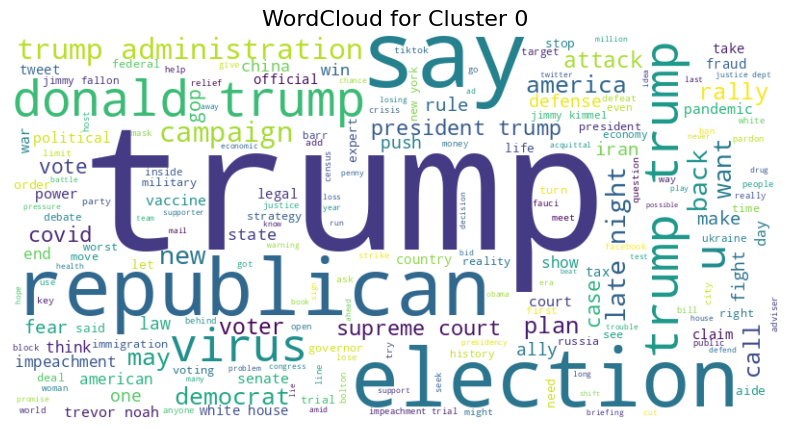

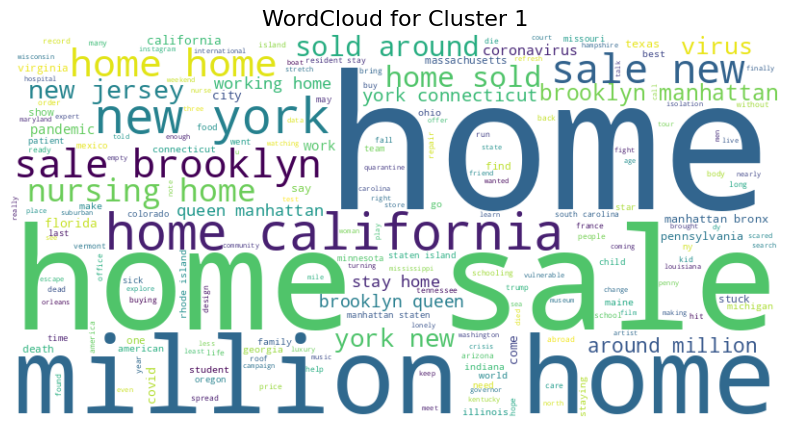

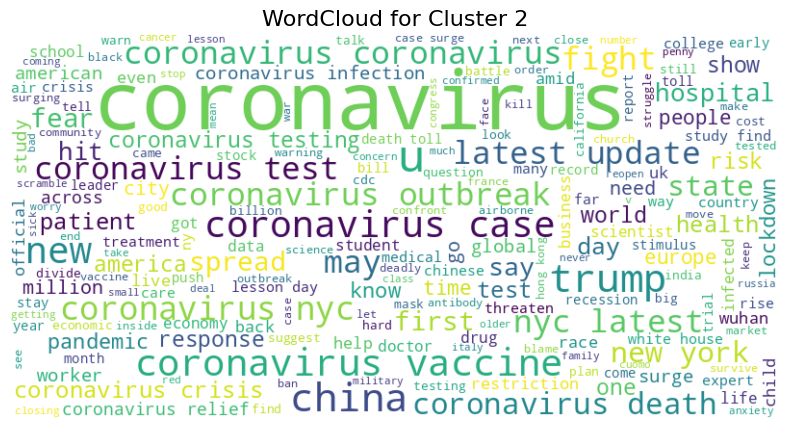

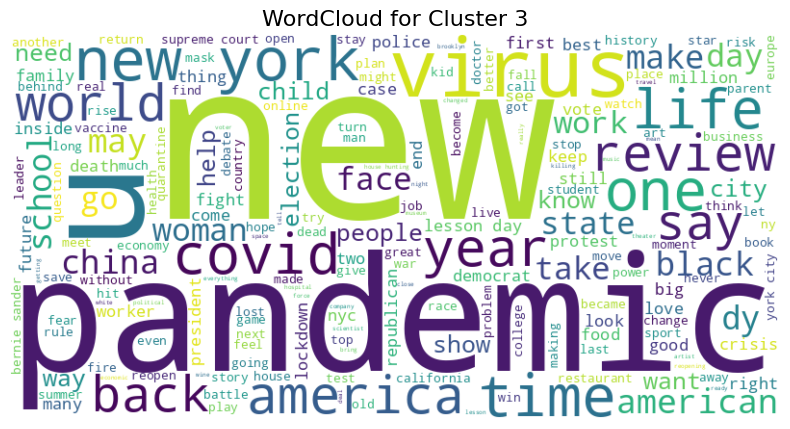

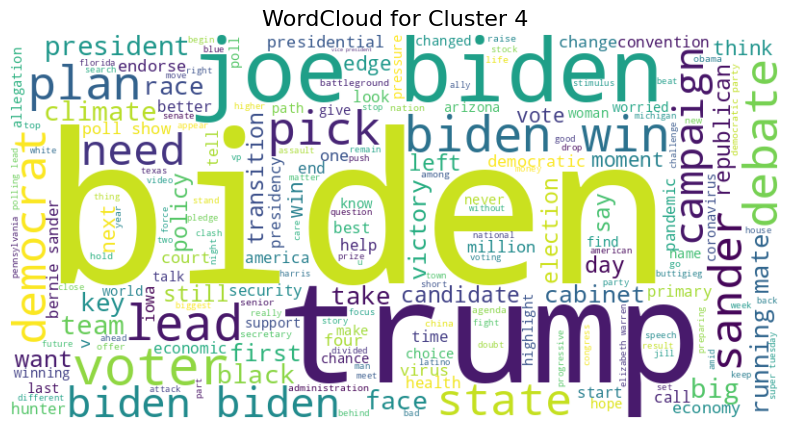

In [19]:
for cluster_num in range(optimal_k):
    cluster_texts = articles[articles['cluster'] == cluster_num]['cleaned_headline']
    full_text = ' '.join(cluster_texts)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(full_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Cluster {cluster_num}', fontsize=16)
    plt.show()


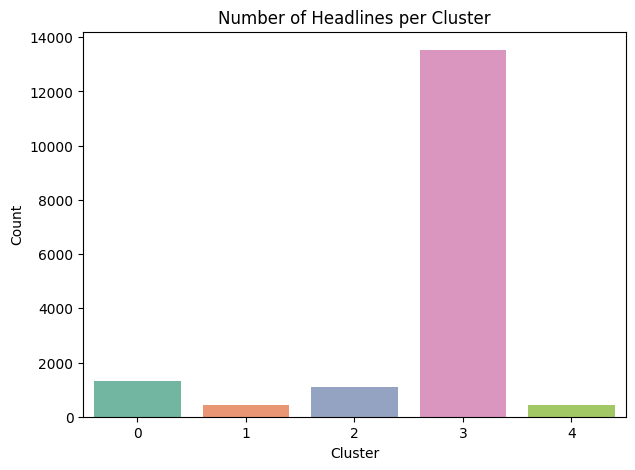

In [20]:
plt.figure(figsize=(7, 5))
sns.countplot(x='cluster', data=articles, palette='Set2')
plt.title('Number of Headlines per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


Top words per LDA topic:
{'Topic 0': ['new', 'york', 'year', 'time', 'one', 'city', 'way', 'could', 'next', 'thing'], 'Topic 1': ['trump', 'biden', 'election', 'day', 'dy', 'court', 'republican', 'president', 'say', 'week'], 'Topic 2': ['coronavirus', 'america', 'covid', 'world', 'death', 'trump', 'may', 'pandemic', 'risk', 'virus'], 'Topic 3': ['home', 'life', 'million', 'review', 'face', 'need', 'american', 'virus', 'california', 'may'], 'Topic 4': ['coronavirus', 'pandemic', 'get', 'like', 'day', 'work', 'black', 'want', 'china', 'back']}


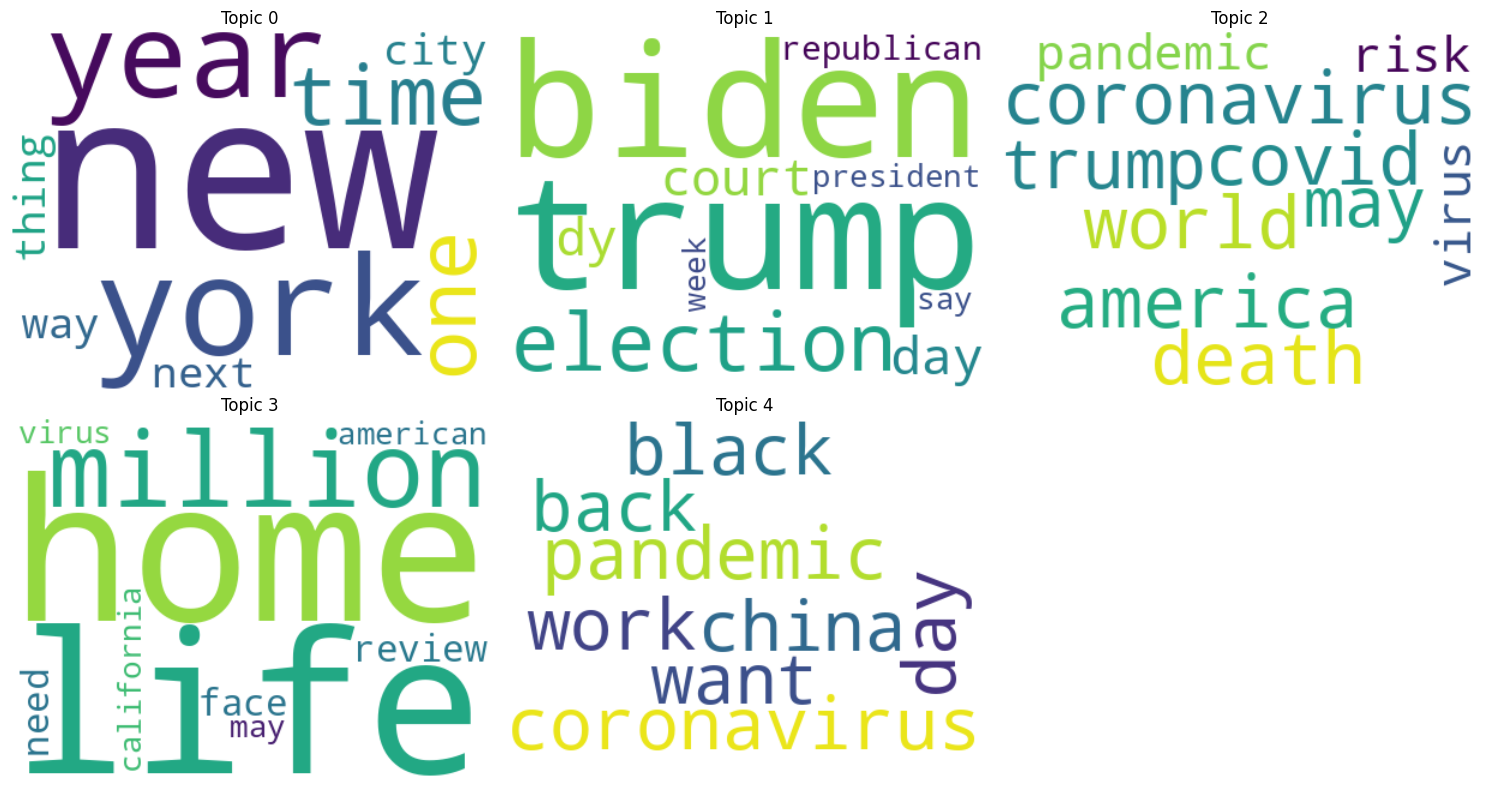

In [21]:
# Convert text to count vectors
count_vectorizer = CountVectorizer(max_features=1000)
X_count = count_vectorizer.fit_transform(articles['cleaned_headline'])

# Train LDA model
num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X_count)

# Extract top words per topic
def get_lda_topics(model, feature_names, n_words=10):
    topics = {}
    for i, topic in enumerate(model.components_):
        words = [feature_names[idx] for idx in topic.argsort()[-n_words:]]
        topics[f'Topic {i}'] = words[::-1]
    return topics

print("Top words per LDA topic:")
print(get_lda_topics(lda, count_vectorizer.get_feature_names_out()))

# WordCloud Visualization
plt.figure(figsize=(15, 8))
for i in range(num_topics):
    plt.subplot(2, 3, i + 1)
    topic_words = ' '.join(get_lda_topics(lda, count_vectorizer.get_feature_names_out())[f'Topic {i}'])
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(topic_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {i}')
plt.tight_layout()
plt.show()

['new', 'york', 'year', 'time', 'one', 'city', 'way', 'could', 'next', 'thing']
🔎 Looks like general/local news, especially New York-related headlines.

Themes like time, city, and events in NY.

🧠 Could label it something like: “Local News & NY Events”

['trump', 'biden', 'election', 'day', 'court', 'republican', 'president', 'say', 'week']
Very clearly U.S. politics: elections, Trump, Biden, courts, Republicans.

🧠 Label: “Politics & Elections”

['coronavirus', 'america', 'covid', 'world', 'death', 'trump', 'may', 'pandemic', 'risk', 'virus']
Heavily focused on COVID-19, public health, and its global/national impact.

🧠 Label: “Global Health Crisis / COVID-19”

['home', 'life', 'million', 'review', 'face', 'american', 'virus', 'california', 'may']
More lifestyle- or personal-impact-oriented — possibly about home life during the pandemic, economic effects (“million”), or product reviews.

🧠 Label: “Lifestyle, Economy, & Impact”

['coronavirus', 'pandemic', 'get', 'like', 'day', 'work', 'black', 'want', 'china', 'back']
Another pandemic-related topic, but with a more behavioral/emotional tone — what people want, going back to work, racial/social themes (“black”), and “china”.

🧠 Label: “COVID Reactions, Society & Return to Normal”

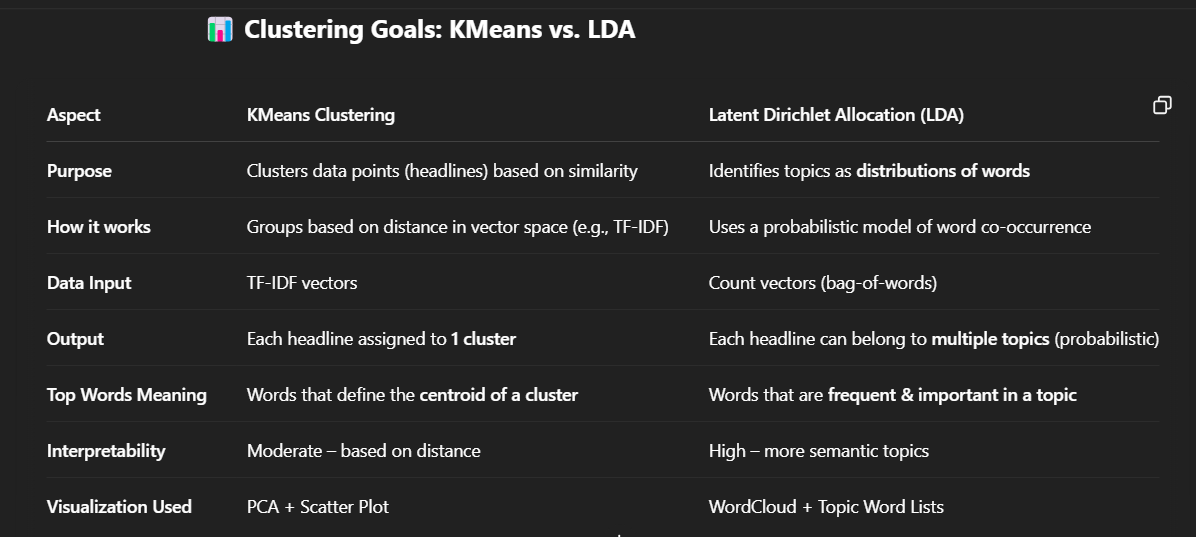


LDA is topic modeling (documents can mix topics), KMeans is clustering (documents grouped exclusively).

Big word = important for that topic/cluster:

In LDA: high probability in topic

In KMeans: high TF-IDF weight in cluster center


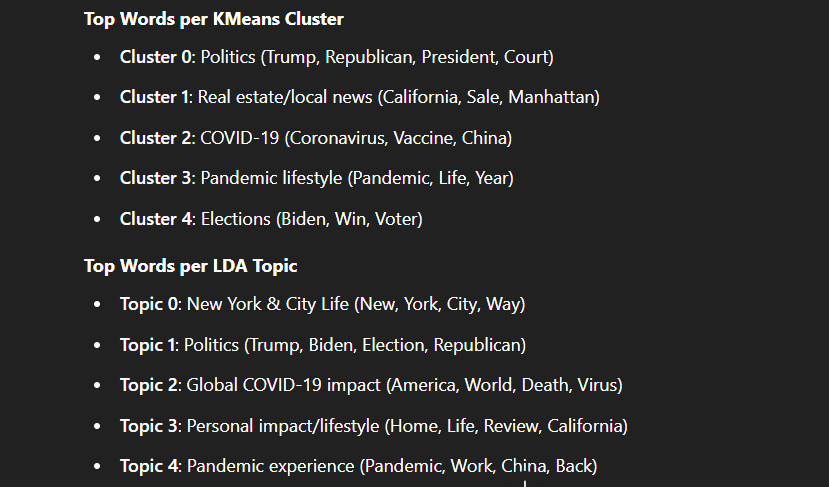


Absolutely, let’s break that line down simply:

---

### 🔍 **What does “documents can mix topics” mean in LDA?**

**LDA** (Latent Dirichlet Allocation) is a **probabilistic model**.

Think of it like this:

- Each document is made up of **a mix of topics**.
- Each topic is made up of **a mix of words**.

For example:

> A headline like: *"Trump discusses vaccine rollout in New York"*

LDA might say:
- 60% Politics  
- 30% Health  
- 10% Local News

So this one headline is **partly about several topics**, not just one.

---

### 📦 **What does “documents grouped exclusively” mean in KMeans?**

**KMeans** is a **hard clustering algorithm**.

It treats each document as a point in space (based on TF-IDF), and then:
- Assigns it to **exactly one cluster** (the nearest one).
- Each document belongs to **only one group**.

For the same headline:
> *"Trump discusses vaccine rollout in New York"*

KMeans might say:
- This belongs to **Cluster 2** only (e.g., "Politics" cluster)

No mixing—just one label.

---

### 🧠 Why does this matter?

- Use **LDA** when your documents might cover multiple **themes/topics**.
- Use **KMeans** when you want to **group** similar documents clearly and exclusively.


In [22]:
# Select a few sample headlines to compare
sample_df = articles[['headline', 'cleaned_headline', 'cluster']].sample(5, random_state=42).copy()

# Transform using the same vectorizers
sample_tfidf = tfidf_vectorizer.transform(sample_df['cleaned_headline'])  # For KMeans (already done)
sample_count = count_vectorizer.transform(sample_df['cleaned_headline'])  # For LDA

# Get LDA topic probabilities
lda_dist = lda.transform(sample_count)
sample_df[['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4']] = lda_dist

# Display KMeans cluster vs LDA topic distribution
pd.set_option('display.max_colwidth', None)
print(sample_df[['headline', 'cluster', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4']])


                                                                  headline  \
10156              Picasso Mural Torn From Building After Years of Dispute   
15209  Nail Salons, Lifeline for Immigrants, Have Lost Half Their Business   
5267                                                   Kicked Out of China   
11723                   Tiwa Savage, Queen of Afrobeats, Makes a New Start   
16039                         2020: The Year in Sports When Everybody Lost   

       cluster   Topic_0   Topic_1   Topic_2   Topic_3   Topic_4  
10156        3  0.733332  0.066667  0.066667  0.066667  0.066667  
15209        3  0.050379  0.051229  0.549085  0.299089  0.050218  
5267         3  0.100000  0.100000  0.100993  0.101753  0.597254  
11723        3  0.302284  0.040579  0.361586  0.040615  0.254936  
16039        3  0.798221  0.050450  0.051099  0.050230  0.050000  
